In [7]:
import requests

# Download dataset
url = 'https://conservancy.umn.edu/bitstreams/fffa78cc-3abf-42b9-b019-bc15a953a8e9/download'
response = requests.get(url)
with open('trashcan_dataset.zip', 'wb') as f:
    f.write(response.content)

In [8]:
import zipfile

# Extract ZIP
with zipfile.ZipFile('trashcan_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('trashcan_dataset')

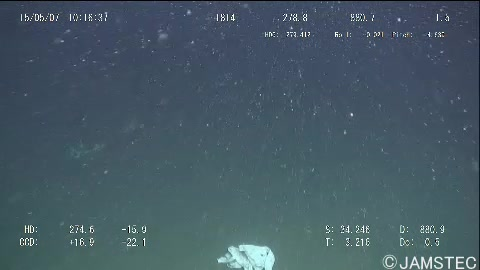

In [9]:
# Display image example
from PIL import Image
import json
import os
from IPython.display import display

# Define paths
image_dir = '/content/trashcan_dataset/dataset/instance_version/train'
annotation_file = '/content/trashcan_dataset/dataset/instance_version/instances_train_trashcan.json'

# Load annotations
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Example: Load an image
image_path = os.path.join(image_dir, 'vid_000002_frame0000023.jpg')
image = Image.open(image_path)

# Display the image
display(image)

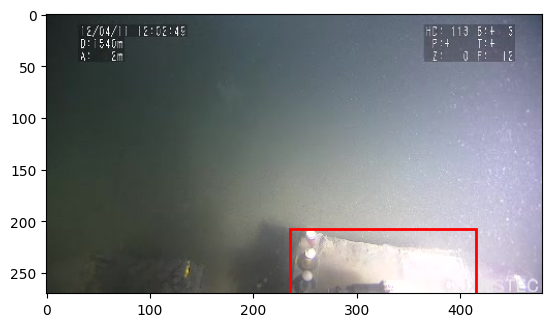

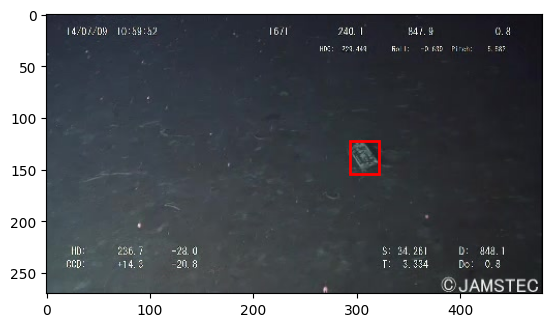

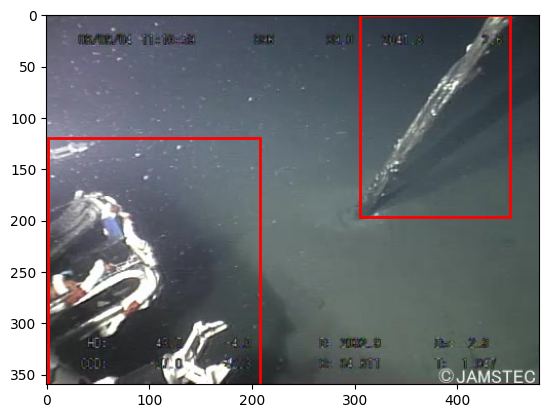

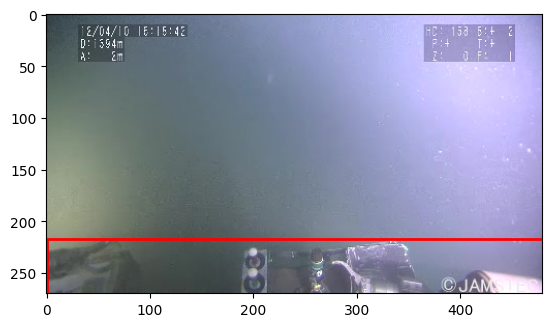

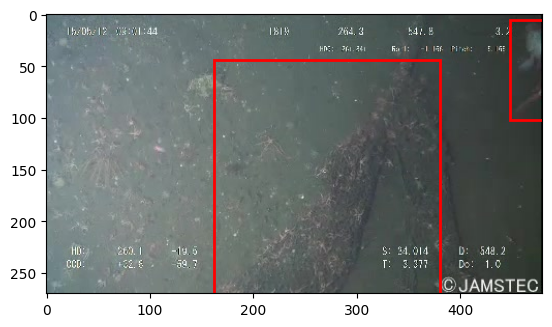

In [12]:
# Visualize bounding boxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import json
import os

# Define paths
image_dir = 'trashcan_dataset/dataset/instance_version/train'
annotation_file = 'trashcan_dataset/dataset/instance_version/instances_train_trashcan.json'

# Load annotations
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Create a mapping from image_id to file_name
image_id_to_file = {img['id']: img['file_name'] for img in annotations['images']}

# Create a mapping from image_id to bounding boxes
image_id_to_boxes = {}
for ann in annotations['annotations']:
    image_id = ann['image_id']
    bbox = ann['bbox']  # [x, y, width, height]
    if image_id not in image_id_to_boxes:
        image_id_to_boxes[image_id] = []
    image_id_to_boxes[image_id].append(bbox)

# Visualize a few examples
for image_id, file_name in list(image_id_to_file.items())[:5]:  # Limit to first 5 images
    # Load the image
    image_path = os.path.join(image_dir, file_name)
    image = Image.open(image_path)

    # Create a plot
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Add bounding boxes
    if image_id in image_id_to_boxes:
        for bbox in image_id_to_boxes[image_id]:
            x, y, width, height = bbox
            rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

    plt.show()

In [11]:
# Convert dataset to YOLO format for training

import os
import json
import shutil

# Define paths
image_dir = 'trashcan_dataset/dataset/instance_version/train'
annotation_file = 'trashcan_dataset/dataset/instance_version/instances_train_trashcan.json'
output_dir = 'trashcan_dataset/yolo_format'

# Create output directories
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'labels'), exist_ok=True)

# Load annotations
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Image size lookup
image_sizes = {img['id']: (img['width'], img['height']) for img in annotations['images']}
image_id_to_file = {img['id']: img['file_name'] for img in annotations['images']}  # Map image_id to file_name

# Convert annotations to YOLO format
for ann in annotations['annotations']:
    image_id = ann['image_id']
    bbox = ann['bbox']
    class_id = ann['category_id']  # Replace with your class-to-id mapping if needed

    # Get image size
    img_width, img_height = image_sizes[image_id]

    # Convert COCO bbox to YOLO bbox
    x, y, width, height = bbox
    x_center = (x + width / 2) / img_width
    y_center = (y + height / 2) / img_height
    width /= img_width
    height /= img_height

    # Prepare YOLO annotation line
    yolo_line = f"{class_id} {x_center} {y_center} {width} {height}\n"

    # Save to YOLO label file
    file_name = os.path.splitext(image_id_to_file[image_id])[0]
    with open(os.path.join(output_dir, 'labels', f"{file_name}.txt"), 'a') as f:
        f.write(yolo_line)

# Copy images to output directory
for img in annotations['images']:
    src = os.path.join(image_dir, img['file_name'])
    dst = os.path.join(output_dir, 'images', img['file_name'])
    shutil.copy2(src, dst)  # Use copy2 to preserve metadata

print("Conversion to YOLO format complete.")

Conversion to YOLO format complete.


In [13]:
!pip install ultralytics

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 887.3/887.3 kB 15.2 MB/s eta 0:00:00


In [14]:
# Write labels to YAML file
import os
import yaml

# Define paths
label_dir = '/content/trashcan_dataset/yolo_format/labels'
yaml_file = '/content/dataset.yaml'

# Collect all unique class IDs from label files
class_ids = set()
for label_file in os.listdir(label_dir):
    label_path = os.path.join(label_dir, label_file)
    with open(label_path, 'r') as f:
        for line in f:
            class_id = int(line.split()[0])  # Extract class ID
            class_ids.add(class_id)

# Sort class IDs (optional, for consistency)
class_ids = sorted(class_ids)

# Compute the number of classes
num_classes = len(class_ids)

# Define the class names (you can modify or generate meaningful names)
class_names = [f'class{i}' for i in class_ids]

# Create the YAML content
yaml_content = {
    'train': '/content/trashcan_dataset/yolo_format/images',
    'val': '/content/trashcan_dataset/yolo_format/images',
    'nc': num_classes,
    'names': class_names
}

# Write the YAML file
with open(yaml_file, 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False)

print(f"YAML file written to {yaml_file}")

YAML file written to /content/dataset.yaml


In [15]:
# View classes
!cat dataset.yaml

names:
- class1
- class2
- class3
- class4
- class5
- class6
- class7
- class8
- class9
- class10
- class11
- class12
- class13
- class14
- class15
- class16
- class17
- class18
- class19
- class20
- class21
- class22
nc: 22
train: /content/trashcan_dataset/yolo_format/images
val: /content/trashcan_dataset/yolo_format/images


In [16]:
# Identify invalid labels, might not be fully correct. Will need to change later.

import os

# Define paths
label_dir = '/content/trashcan_dataset/yolo_format/labels'
valid_classes = set(range(10))  # Adjust according to the number of valid classes (0-9)
invalid_labels = []  # To store files with invalid labels

# Check and fix invalid classes in label files
for label_file in os.listdir(label_dir):
    label_path = os.path.join(label_dir, label_file)
    corrected_lines = []
    has_invalid_class = False
    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            class_id, *bbox = line.split()
            class_id = int(class_id)
            if class_id in valid_classes:
                corrected_lines.append(line)  # Keep valid lines
            else:
                has_invalid_class = True

    # Write corrected labels back
    if corrected_lines:
        with open(label_path, 'w') as f:
            f.writelines(corrected_lines)
    else:
        # If no valid labels remain, delete the label file
        os.remove(label_path)

    if has_invalid_class:
        invalid_labels.append(label_file)

print(f"Invalid labels found in: {invalid_labels}")

Invalid labels found in: ['vid_000109_frame0000037.txt', 'vid_000255_frame0000021.txt', 'vid_000294_frame0000011.txt', 'vid_000291_frame0000023.txt', 'vid_000255_frame0000012.txt', 'vid_000080_frame0000053.txt', 'vid_000169_frame0000003.txt', 'vid_000292_frame0000003.txt', 'vid_000291_frame0000026.txt', 'vid_000369_frame0000016.txt', 'vid_000048_frame0000024.txt', 'vid_000553_frame0000013.txt', 'vid_000075_frame0000180.txt', 'vid_000077_frame0000005.txt', 'vid_000240_frame0000064.txt', 'vid_000055_frame0000095.txt', 'vid_000171_frame0000006.txt', 'vid_000162_frame0000046.txt', 'vid_000146_frame0000007.txt', 'vid_000031_frame0000045.txt', 'vid_000280_frame0000031.txt', 'vid_000077_frame0000002.txt', 'vid_000279_frame0000007.txt', 'vid_000288_frame0000042.txt', 'vid_000205_frame0000021.txt', 'vid_000113_frame0000005.txt', 'vid_000162_frame0000008.txt', 'vid_000138_frame0000030.txt', 'vid_000295_frame0000011.txt', 'vid_000155_frame0000031.txt', 'vid_000302_frame0000004.txt', 'vid_000350_f

In [17]:
# Update invalid classes
import yaml

# Recompute classes
class_ids = set()
for label_file in os.listdir(label_dir):
    label_path = os.path.join(label_dir, label_file)
    with open(label_path, 'r') as f:
        for line in f:
            class_id = int(line.split()[0])
            class_ids.add(class_id)

# Sort and create class names
class_ids = sorted(class_ids)
num_classes = len(class_ids)
class_names = [f'class{i}' for i in class_ids]

# Write to YAML
yaml_content = {
    'train': '/content/trashcan_dataset/yolo_format/images',
    'val': '/content/trashcan_dataset/yolo_format/images',
    'nc': num_classes,
    'names': class_names
}

with open('/content/dataset.yaml', 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False)

print("Updated dataset.yaml created.")

Updated dataset.yaml created.


In [18]:
!ls /content/trashcan_dataset/yolo_format/labels

vid_000002_frame0000023.txt  vid_000147_frame0000009.txt  vid_000291_frame0000049.txt
vid_000003_frame0000007.txt  vid_000147_frame0000010.txt  vid_000291_frame0000050.txt
vid_000003_frame0000008.txt  vid_000147_frame0000011.txt  vid_000291_frame0000051.txt
vid_000005_frame0000011.txt  vid_000147_frame0000012.txt  vid_000291_frame0000052.txt
vid_000005_frame0000012.txt  vid_000147_frame0000013.txt  vid_000291_frame0000053.txt
vid_000021_frame0000010.txt  vid_000147_frame0000014.txt  vid_000291_frame0000054.txt
vid_000021_frame0000013.txt  vid_000147_frame0000015.txt  vid_000291_frame0000055.txt
vid_000021_frame0000016.txt  vid_000147_frame0000016.txt  vid_000291_frame0000056.txt
vid_000021_frame0000017.txt  vid_000147_frame0000017.txt  vid_000291_frame0000057.txt
vid_000021_frame0000018.txt  vid_000147_frame0000018.txt  vid_000291_frame0000058.txt
vid_000021_frame0000019.txt  vid_000147_frame0000019.txt  vid_000291_frame0000059.txt
vid_000021_frame0000020.txt  vid_000147_frame0000020.t

In [19]:
!cat dataset.yaml

names:
- class1
- class2
- class3
- class4
- class5
- class6
- class7
- class8
- class9
nc: 9
train: /content/trashcan_dataset/yolo_format/images
val: /content/trashcan_dataset/yolo_format/images


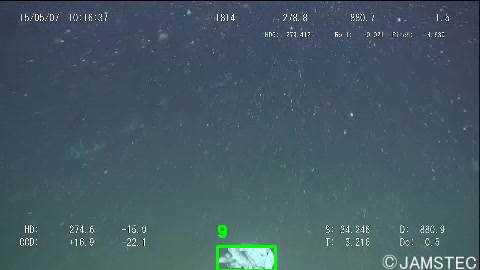

In [21]:
# View labels and bounding boxes
import cv2
from google.colab.patches import cv2_imshow # Import cv2_imshow from google.colab.patches for colab notebooks

# Visualize a sample image with bounding boxes
image_dir = '/content/trashcan_dataset/yolo_format/images'
sample_image = 'vid_000002_frame0000023.jpg'  # Replace with an actual image file
label_path = os.path.join(label_dir, os.path.splitext(sample_image)[0] + '.txt')

image = cv2.imread(os.path.join(image_dir, sample_image))

with open(label_path, 'r') as f:
    for line in f:
        class_id, x_center, y_center, width, height = map(float, line.split())
        h, w, _ = image.shape
        x1 = int((x_center - width / 2) * w)
        y1 = int((y_center - height / 2) * h)
        x2 = int((x_center + width / 2) * w)
        y2 = int((y_center + height / 2) * h)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, str(int(class_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Replace cv2.imshow() with cv2_imshow()
cv2_imshow(image)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [22]:
# NOTE: Does not currently work, will need to fix later

from ultralytics import YOLO

# Load a YOLOv10 model (pre-trained or scratch)
model = YOLO('yolov10n')

# Train the model
# One epoch for testing
model.train(data='dataset.yaml', epochs=1, imgsz=640, batch=16)

# Validate the model
metrics = model.val()

# Export the model
model.export(format='onnx')  # Optional: export to ONNX format

Creating new Ultralytics Settings v0.0.6 file ‚úÖ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5.59M/5.59M [00:00<00:00, 15.8MB/s]


Ultralytics 8.3.36 üöÄ Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=dataset.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 755k/755k [00:00<00:00, 3.16MB/s]


Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5.35M/5.35M [00:00<00:00, 18.1MB/s]


AMP: checks passed ‚úÖ


train: Scanning /content/trashcan_dataset/yolo_format/labels... 3245 images, 2820 backgrounds, 255 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6065/6065 [00:03<00:00, 1597.36it/s]

train: WARNING ‚ö†Ô∏è /content/trashcan_dataset/yolo_format/images/vid_000002_frame0000023.jpg: 1 duplicate labels removed
train: WARNING ‚ö†Ô∏è /content/trashcan_dataset/yolo_format/images/vid_000003_frame0000007.jpg: 1 duplicate labels removed
train: WARNING ‚ö†Ô∏è /content/trashcan_dataset/yolo_format/images/vid_000003_frame0000008.jpg: 1 duplicate labels removed
train: WARNING ‚ö†Ô∏è /content/trashcan_dataset/yolo_format/images/vid_000005_frame0000011.jpg: 1 duplicate labels removed
train: WARNING ‚ö†Ô∏è /content/trashcan_dataset/yolo_format/images/vid_000005_frame0000012.jpg: 1 duplicate labels removed
train: WARNING ‚ö†Ô∏è /content/trashcan_dataset/yolo_format/images/vid_000021_frame0000010.jpg: 2 duplicate labels removed
train: WARNING ‚ö†Ô∏è /content/trashcan_dataset/yolo_format/images/vid_000021_frame0000013.jpg: 2 duplicate labels removed
train: WARNING ‚ö†Ô∏è /content/trashcan_dataset/yolo_format/images/vid_000021_frame0000016.jpg: 2 duplicate labels removed
train: WARNING ‚

train: New cache created: /content/trashcan_dataset/yolo_format/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/trashcan_dataset/yolo_format/labels.cache... 3245 images, 2820 backgrounds, 255 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6065/6065 [00:00<?, ?it/s]

train: WARNING ‚ö†Ô∏è /content/trashcan_dataset/yolo_format/images/vid_000002_frame0000023.jpg: 1 duplicate labels removed
train: WARNING ‚ö†Ô∏è /content/trashcan_dataset/yolo_format/images/vid_000003_frame0000007.jpg: 1 duplicate labels removed
train: WARNING ‚ö†Ô∏è /content/trashcan_dataset/yolo_format/images/vid_000003_frame0000008.jpg: 1 duplicate labels removed
train: WARNING ‚ö†Ô∏è /content/trashcan_dataset/yolo_format/images/vid_000005_frame0000011.jpg: 1 duplicate labels removed
train: WARNING ‚ö†Ô∏è /content/trashcan_dataset/yolo_format/images/vid_000005_frame0000012.jpg: 1 duplicate labels removed
train: WARNING ‚ö†Ô∏è /content/trashcan_dataset/yolo_format/images/vid_000021_frame0000010.jpg: 2 duplicate labels removed
train: WARNING ‚ö†Ô∏è /content/trashcan_dataset/yolo_format/images/vid_000021_frame0000013.jpg: 2 duplicate labels removed
train: WARNING ‚ö†Ô∏è /content/trashcan_dataset/yolo_format/images/vid_000021_frame0000016.jpg: 2 duplicate labels removed
train: WARNING ‚

Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ‚úÖ
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      2.99G      4.295      49.78      3.706          5        640:   0%|          | 1/364 [00:01<10:07,  1.67s/it]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
